# Restaurant Topicnizer

#### By Ari Conati, Matti Kukkamäki, Savanna Lujan

Web App Description Placeholder

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from ipywidgets import Layout
from ipywidgets import HBox, VBox
from ipywidgets import Dropdown

NUM_TOPICS = 5
TOPICS = ["Topic{}".format(i) for i in range(NUM_TOPICS)]

In [5]:
def get_weighted_averages(df, num_topics):                                                             
    topic_q = {"Topic{}".format(i): df["Topic{}".format(i)].sum() for i in range(num_topics)}
    topic_wa = {"Topic{}".format(i): (df["stars"]*df["Topic{}".format(i)]).sum()/topic_q["Topic{}".format(i)] for i in range(num_topics)}
    return topic_wa


def weighted_averages_by_year(df, num_topics):
    years = df["year"].unique()
    year_dfs = [df[df['year'] == years[i]] for i in range(len(years))]
    topic_dfs = [[] for i in range(num_topics)]
    for i, year_df in enumerate(year_dfs):
        topic_wa = get_weighted_averages(year_df, num_topics)
        for x in range(num_topics):
            topic_dfs[x].append((years[i], topic_wa["Topic{}".format(x)]))
            
    topic_dfs = [pd.DataFrame(x, columns=['year', 'score']) for x in topic_dfs]
    topic_dfs = [x.sort_values(["year"]) for x in topic_dfs]
    return topic_dfs

In [23]:
directory = os.fsencode("RestaurantData")
restaurant_files = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        restaurant_files.append(os.path.join(os.fsdecode(directory), filename))
        
raw_dfs = [pd.read_csv(x) for x in restaurant_files]
restaurant_dfs = [weighted_averages_by_year(x, NUM_TOPICS) for x in raw_dfs]
overall_dfs = [get_weighted_averages(x, NUM_TOPICS) for x in raw_dfs]
overall_dfs = [pd.DataFrame(data={"Topic": TOPICS, "Score": [x[topic] for topic in TOPICS]}) for x in overall_dfs]

restaurant_names = [os.path.splitext(filename)[0] for filename in restaurant_files]
restaurant_names = [filename.replace('_', ' ')[filename.index("/")+1:] for filename in restaurant_names]
restaurant_names = [" ".join(filename.split()[:-2]) for filename in restaurant_names]

overall_dfs[0]

,Topic,Score
0,Topic0,3.439923
1,Topic1,2.980569
2,Topic2,3.085647
3,Topic3,3.440731
4,Topic4,3.341612


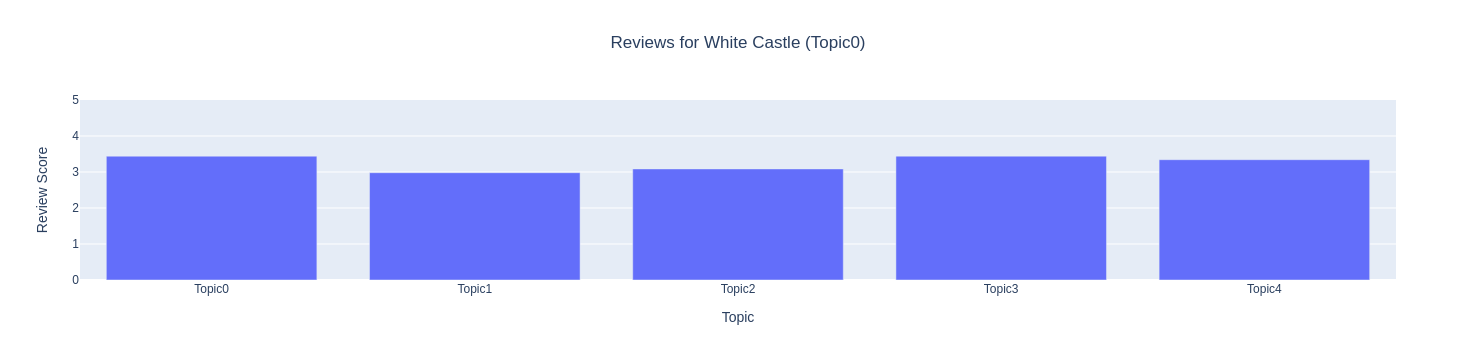

In [28]:
x_label = "Year"
y_label = "Review Score"
df = restaurant_dfs[0][0]
overall = overall_dfs[0]

g = go.FigureWidget(data=go.Scatter(x=df["year"], y=df["score"]),
                   layout=go.Layout(
                   title={
                       "text": "Reviews for {} ({})".format(restaurant_names[0], TOPICS[0]),
                       "x": 0.5,
                       "y": 0.9,
                       "xanchor": "center",
                       "yanchor": "top"},
                       xaxis_title=x_label,
                       yaxis_title=y_label
                   ))

g_over = go.FigureWidget(data=go.Bar(x=overall["Topic"], y=overall["Score"]),
                   layout=go.Layout(
                   title={
                       "text": "Reviews for {} ({})".format(restaurant_names[0], TOPICS[0]),
                       "x": 0.5,
                       "y": 0.9,
                       "xanchor": "center",
                       "yanchor": "top"},
                       xaxis_title="Topic",
                       yaxis_title=y_label,
                       yaxis=dict(
                           range=[0,5]
                       )
                   ))
g_over.show()

In [8]:
select_topic = Dropdown(options = TOPICS, layout=Layout(width = '160px'))
select_restaurant = Dropdown(options = restaurant_names, layout=Layout(width = '160px'))


def update(change):
    with g.batch_update():
        index_t = TOPICS.index(select_topic.value)
        index_r = restaurant_names.index(select_restaurant.value)
        g.data[0].y = restaurant_dfs[index_r][index_t]["score"]
        g.layout = layout=go.Layout(
                       title={
                           "text": "Reviews for {} ({})".format(restaurant_names[index_r], TOPICS[index_t]),
                           "x": 0.5,
                           "y": 0.9,
                           "xanchor": "center",
                           "yanchor": "top"},
                           xaxis_title=x_label,
                           yaxis_title=y_label
                       )

select_topic.observe(update, names="value")
select_restaurant.observe(update, names="value")

dropdown = HBox([select_restaurant, select_topic])
gd = VBox([dropdown, g])
gd